In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/base_210/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/base_210/checkpoints/106000_0.0930.pt


In [7]:
args = checkpoint['args']

In [8]:
args['data']['data_loc']

'./data/2^16.json'

In [9]:
data_utils.gfm = data_utils.GlobalFactorMapping(data_path = '.' + args['data']['data_loc'] if args['data']['data_loc'].endswith('.json') else \
                                          args['data']['data_loc'] + '2^%d.json'%args['data']['max_pow'])

In [10]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [11]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'tokenizer'])

In [12]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(214, 128)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
           

# Visualize Embeddings

In [13]:
embeddings = model.embedding.embedding.weight.data.cpu().numpy()

In [14]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [15]:
embeddings.shape

(214, 128)

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

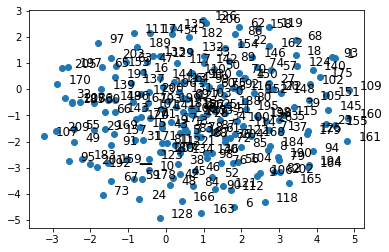

In [18]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
cs_sims = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sims, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

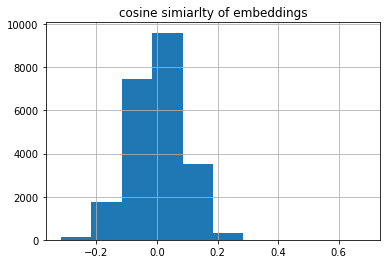

In [21]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [23]:
# logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
logreg = SVC()

In [24]:
embeddings.shape, tokens.shape

((214, 128), (214,))

In [25]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [26]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [27]:
logreg_x_train.shape, logreg_y_train.shape

((176, 128), (176,))

In [28]:
logreg_x_test.shape, logreg_y_test.shape

((34, 128), (34,))

In [29]:
logreg.fit(logreg_x_train, logreg_y_train)

SVC()

In [30]:
logreg.score(logreg_x_test, logreg_y_test)

0.9117647058823529

# How well does the model do on numbers higher than what it was trained on?

In [43]:
start = 2**16
numbers = np.arange(2**16, 2**16 + 4096)

In [44]:
import importlib
importlib.reload(metrics_utils)
importlib.reload(generation_utils)

<module 'generation_utils' from '../src\\generation_utils.py'>

In [45]:
t

In [46]:
t.encode(data_utils.form_input([1, 102, 16]))

[213, 1, 102, 16, 212]

In [47]:
larger_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], numbers, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [48]:
larger_df.shape

(40960, 7)

In [49]:
larger_df.head(5)

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization
0,65536,0,-0.012336,"[2, 2, 2, 8087]",64696,False,False
1,65536,1,-5.144893,"[2, 2, 2, 11, 17, 41]",61336,False,False
2,65536,2,-7.382161,"[2, 2, 2, 5987]",47896,False,False
3,65536,3,-7.485180,"[2, 2, 2, 2, 13, 307]",63856,False,False
4,65536,4,-7.534582,"[2, 2, 2, 2, 2, 13, 103]",42848,False,False


In [52]:
larger_df.groupby('target_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.110107
dtype: float64

In [63]:
top_beams = larger_df['beam_idx'] == 9
(larger_df[top_beams]['product'] < larger_df[top_beams]['target_num']).mean()

0.834228515625